adapted from https://blog.scientific-python.org/matplotlib/draw-all-graphs-of-n-nodes/

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from ogb.graphproppred import PygGraphPropPredDataset
from torch_geometric.datasets import ZINC
import tqdm
from torch_geometric.utils import to_networkx
from torch_geometric.datasets import PCQM4Mv2


In [2]:
def plot_graphs(
        graphs,
        figsize=14,
        dotsize=20,
        avgs=None,
        stds=None,
        zero_counts=None,
        title_fontsize=14):
    n = len(graphs)
    k = int(np.ceil(np.sqrt(n)))          # minimal square grid
    fig = plt.figure(figsize=(figsize, figsize), facecolor="white")

    for i, edges in enumerate(graphs):
        ax = plt.subplot(k, k, i + 1)
        g = nx.Graph()
        g.add_edges_from(edges)

        # draw graphlet
        nx.draw_kamada_kawai(g, node_size=dotsize, ax=ax)
        ax.axis("off")

        # compose caption for this subplot
        caption_lines = []
        if avgs is not None and stds is not None:
            caption_lines.append(f"{avgs[i]:.2f}±{stds[i]:.2f}")
        if zero_counts is not None:
            caption_lines.append(f"No-hit graphs: {zero_counts[i]}")
        if caption_lines:
            ax.set_title("\n".join(caption_lines),
                         fontsize=title_fontsize,
                         pad=6)

    # tidy spacing so titles don’t overlap neighbouring axes
    plt.tight_layout()
    plt.show()


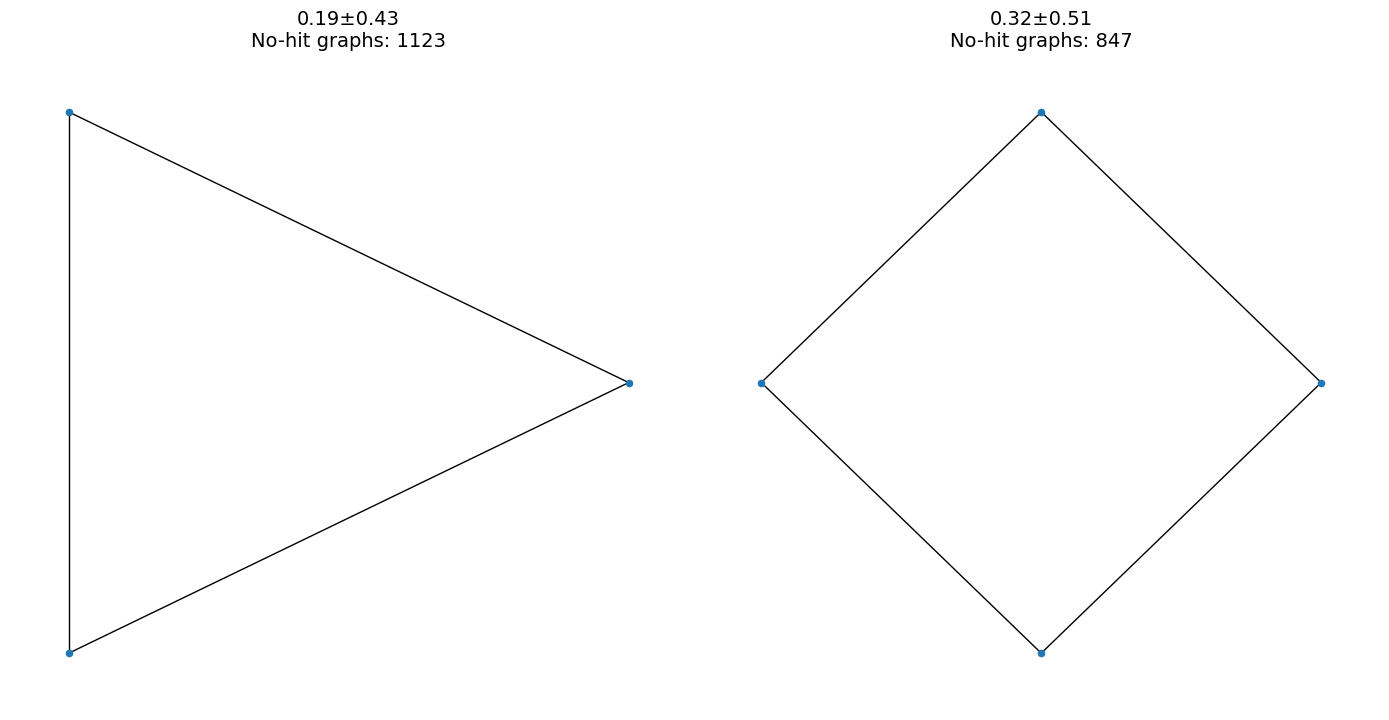

In [3]:
graphlets   = [[(0,1), (1,2), (2,0)],      # triangle
               [(0,1), (1,2), (2,3), (3,0)]]  # 4-cycle

totals      = [ 7850,  12942]
avgs        = [ 0.19,   0.32]
stds        = [ 0.43,   0.51]
zero_counts = [1123,    847]

plot_graphs(graphlets,
            avgs=avgs,
            stds=stds,
            zero_counts=zero_counts)


[(0, 1), (0, 2), (1, 2)]
[(0, 1), (0, 2)]
[(0, 1), (1, 2)]
[(0, 1)]
Drawing...


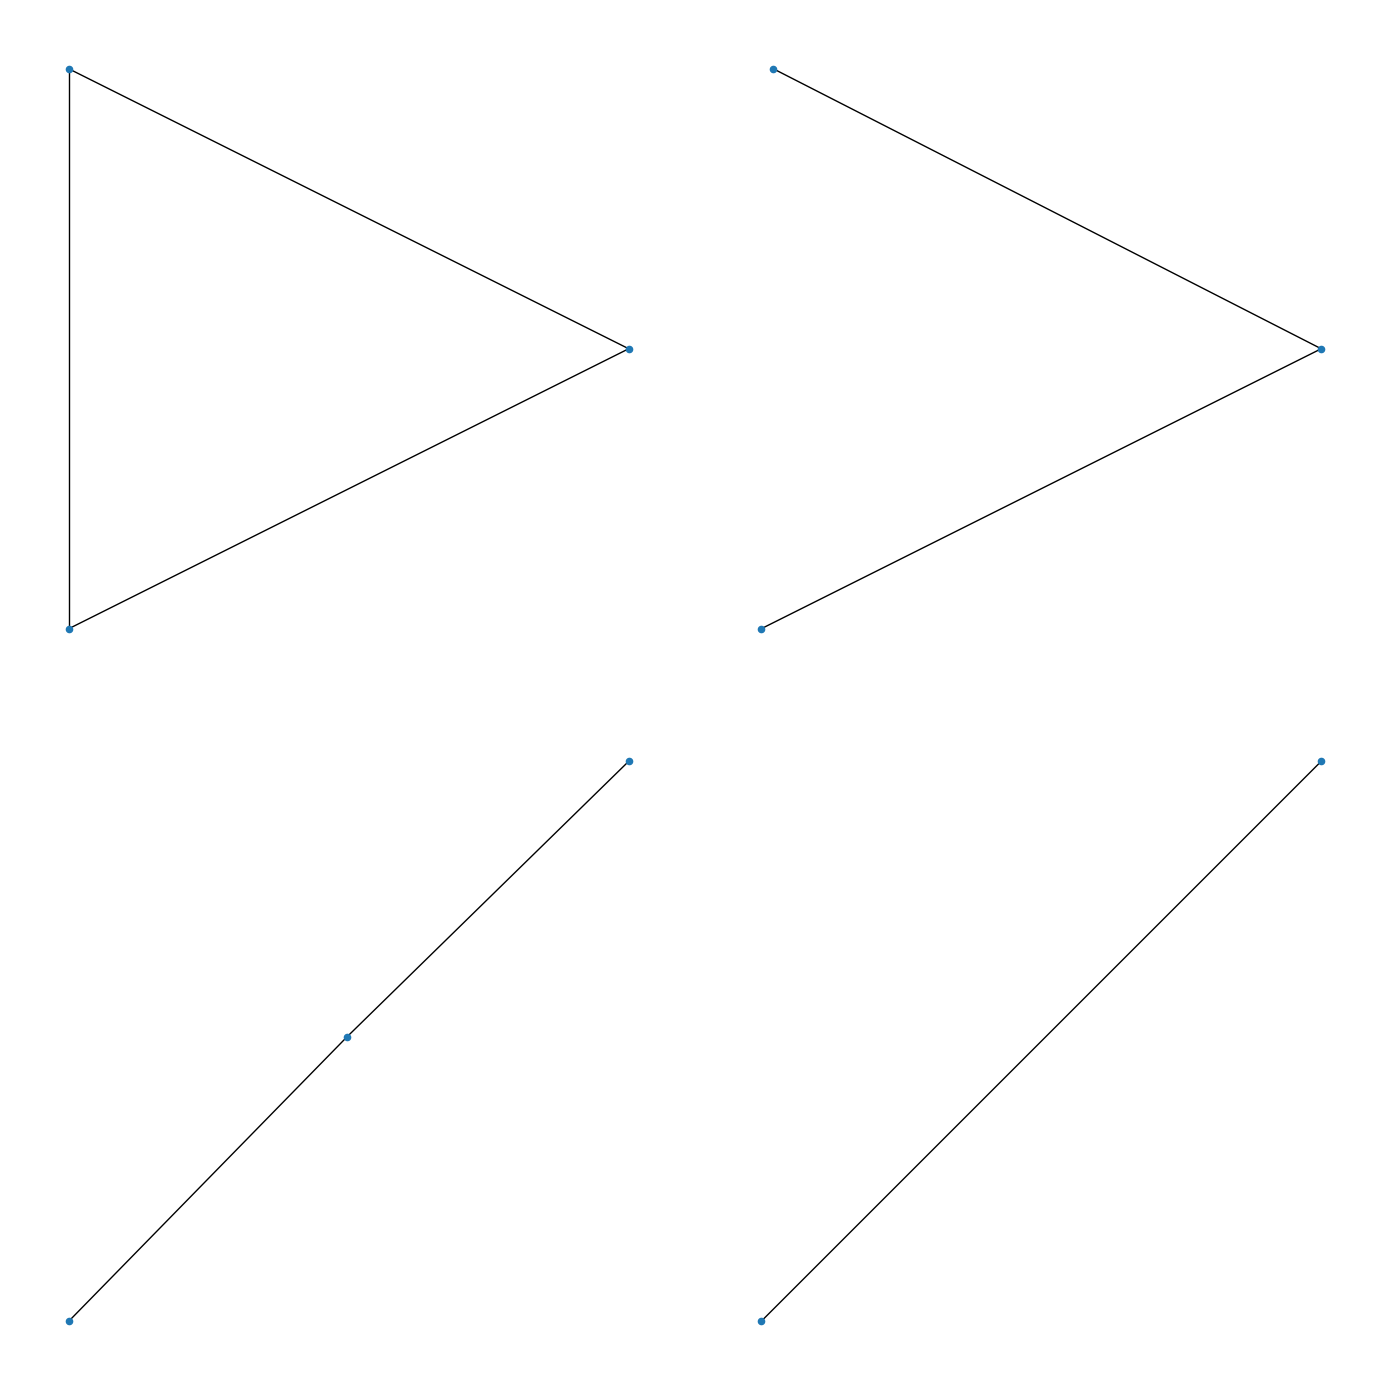

In [4]:
def make_graphs(n=2, i=None, j=None):
    """Make a graph recursively, by either including, or skipping each edge.
    Edges are given in lexicographical order by construction."""
    out = []
    if i is None: # First call
        out  = [[(0,1)]+r for r in make_graphs(n=n, i=0, j=1)]
    elif j<n-1:
        out += [[(i,j+1)]+r for r in make_graphs(n=n, i=i, j=j+1)]
        out += [          r for r in make_graphs(n=n, i=i, j=j+1)]
    elif i<n-1:
        out = make_graphs(n=n, i=i+1, j=i+1)
    else:
        out = [[]]
    return out
                                                  
gs = make_graphs(3)
for g in gs: print(g)
print('Drawing...')
plot_graphs(gs)

In [5]:
def perm(n, s=None):
    """All permutations of n elements."""
    if s is None: return perm(n, tuple(range(n)))
    if not s: return [[]]
    return [[i]+p for i in s for p in perm(n, tuple([k for k in s if k!=i]))]
def permute(g, n):
    """Create a set of all possible isomorphic codes for a graph, 
    as nice hashable tuples. All edges are i<j, and sorted lexicographically."""
    ps = perm(n)
    out = set([])
    for p in ps:
        out.add(tuple(sorted([(p[i],p[j]) if p[i]<p[j] else (p[j],p[i]) for i,j in g])))
    return list(out)
def connected(g):
    """Check if the graph is fully connected, with Union-Find."""
    nodes = set([i for e in g for i in e])
    roots = {node: node for node in nodes}
    
    def _root(node, depth=0):
        if node==roots[node]: return (node, depth)
        else: return _root(roots[node], depth+1)
    
    for i,j in g:
        ri,di = _root(i)
        rj,dj = _root(j)
        if ri==rj: continue
        if di<=dj: roots[ri] = rj
        else:      roots[rj] = ri
    return len(set([_root(node)[0] for node in nodes]))==1

assert connected([(0, 1), (0, 2), (1, 3)])
assert not connected([(0, 1), (2, 3)])           
def filter(gs, target_nv):
    """Filter all improper graphs: those with not enough nodes, 
    those not fully connected, and those isomorphic to previously considered."""
    mem = set({})
    gs2 = []
    for g in gs:
        nv = len(set([i for e in g for i in e]))
        if nv != target_nv:
            continue
        if not connected(g):
            continue
        if tuple(g) not in mem:
            gs2.append(g)
            mem |= set(permute(g, target_nv))
        #print('\n'.join([str(a) for a in mem]))
    return gs2

Building...
Filtering...
Drawing 112 graphs...


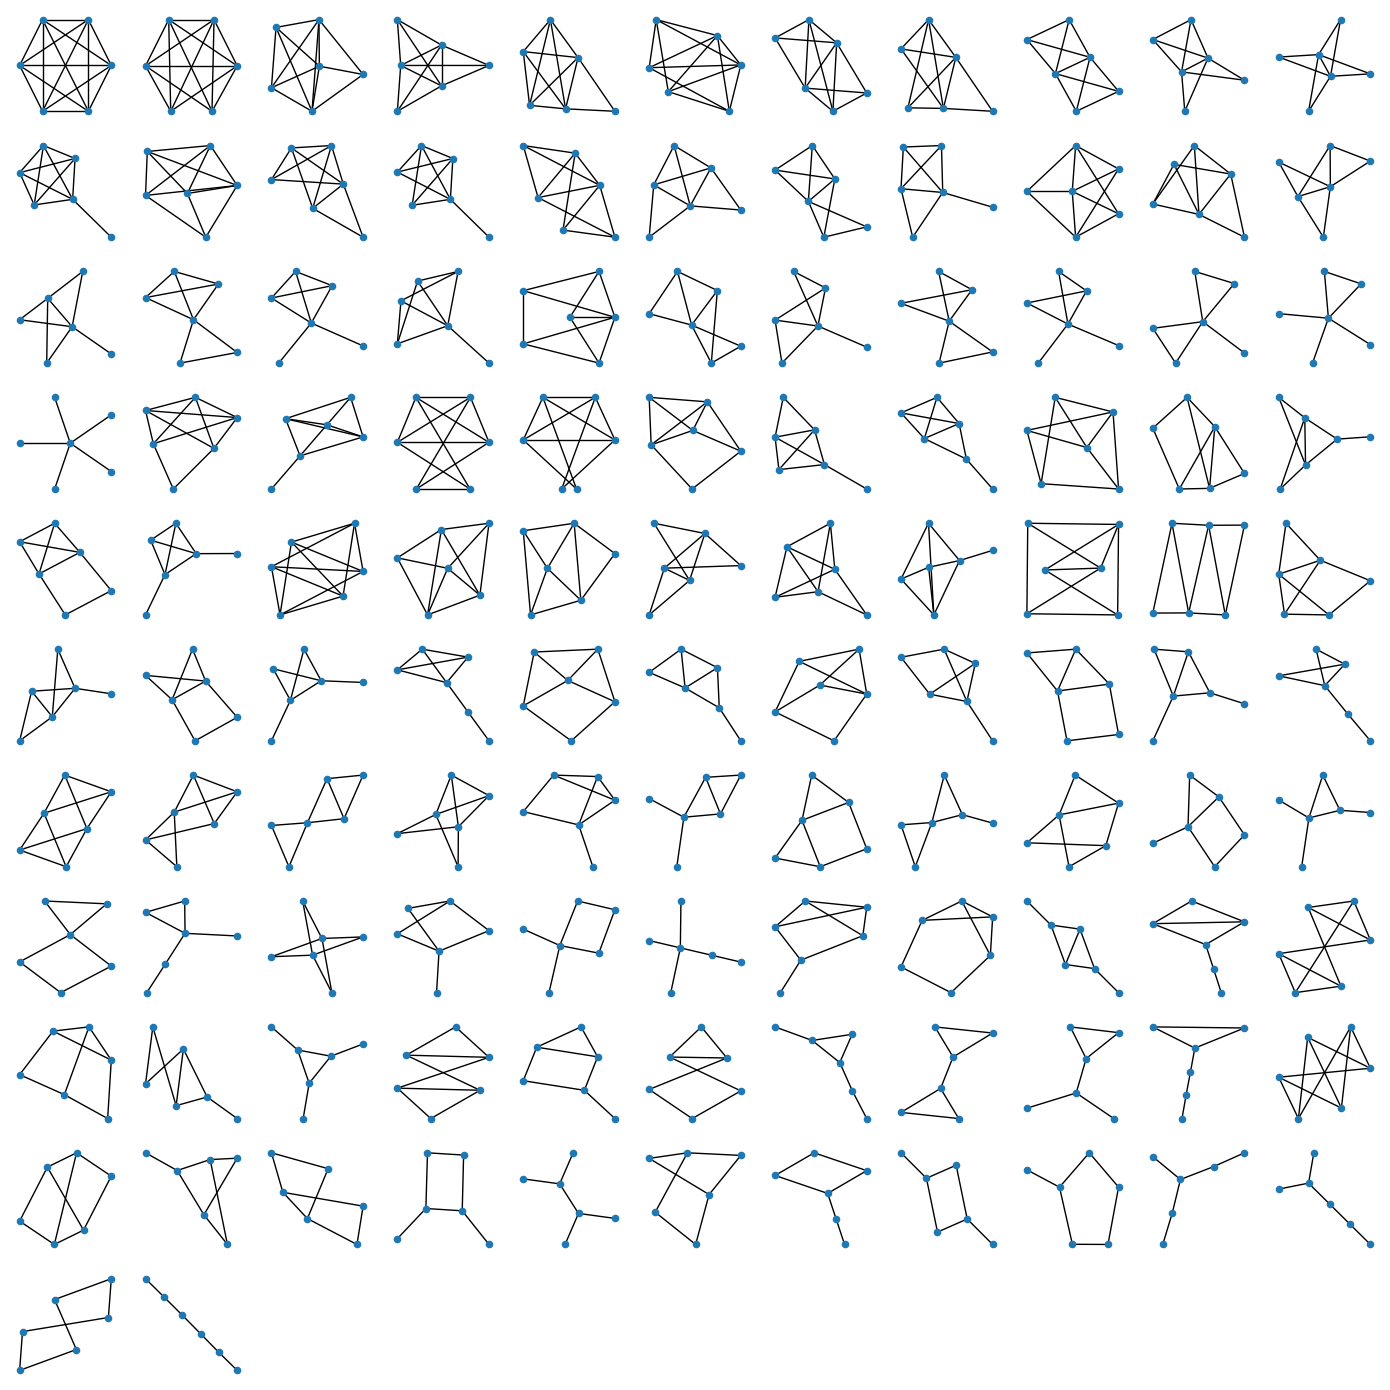

In [6]:
NV = 6
print('Building...')
all_graphs = make_graphs(NV)
print('Filtering...')
all_graphs = filter(all_graphs, NV)
print(f'Drawing {len(all_graphs)} graphs...')
plot_graphs(all_graphs, figsize=14, dotsize=20)

In [7]:
# dataset = PygGraphPropPredDataset(name="ogbg-molhiv", root="../data")
# dataset = ZINC("../data", subset=True, split="train")

In [10]:
dataset = PCQM4Mv2(root='./data/pcqm4m-v2', split='train')
dataset, dataset.len()

Extracting data/pcqm4m-v2/raw/pcqm4m-v2.zip
Processing...
100%|██████████| 3747/3747 [00:13<00:00, 287.39it/s]
Done!


(PCQM4Mv2(3378606), 3747)

In [ ]:
def find_uniques(G, gpattern):
    unique_subgraphs = []
    out = []
    matcher = nx.algorithms.isomorphism.GraphMatcher(G, gpattern)
    for mapping in matcher.subgraph_isomorphisms_iter():
        # Convert mapping values to a frozenset of node IDs (order doesn't matter)
        subgraph_nodes = frozenset(mapping.keys())
        if subgraph_nodes not in unique_subgraphs:
            unique_subgraphs.append(frozenset(mapping.keys()))
            out.append(list(mapping.keys()))
    return out

def get_subgraph_counts(all_graphs, dataset):
    all_graphs = [nx.Graph(g) for g in all_graphs]

    all_counts = [[] for _ in all_graphs]
    zero_counts = [0 for _ in all_graphs]

    for i in tqdm.tqdm(len(dataset)):
        data = dataset[i]
        G = to_networkx(data, to_undirected=True)
        G = nx.convert_node_labels_to_integers(G)

        for i, gpattern in enumerate(all_graphs):
            match_count = len(find_uniques(G, gpattern))

            all_counts[i].append(match_count)
            if match_count == 0:
                zero_counts[i] += 1


    avg_counts = [np.mean(c) for c in all_counts]
    std_counts = [np.std(c) for c in all_counts]
    return avg_counts, std_counts, zero_counts

avg_counts, std_counts, zero_counts = get_subgraph_counts(all_graphs, dataset)

  0%|          | 0/3378606 [00:00<?, ?it/s]

  0%|          | 766/3378606 [00:24<29:51:03, 31.43it/s]


KeyboardInterrupt: 

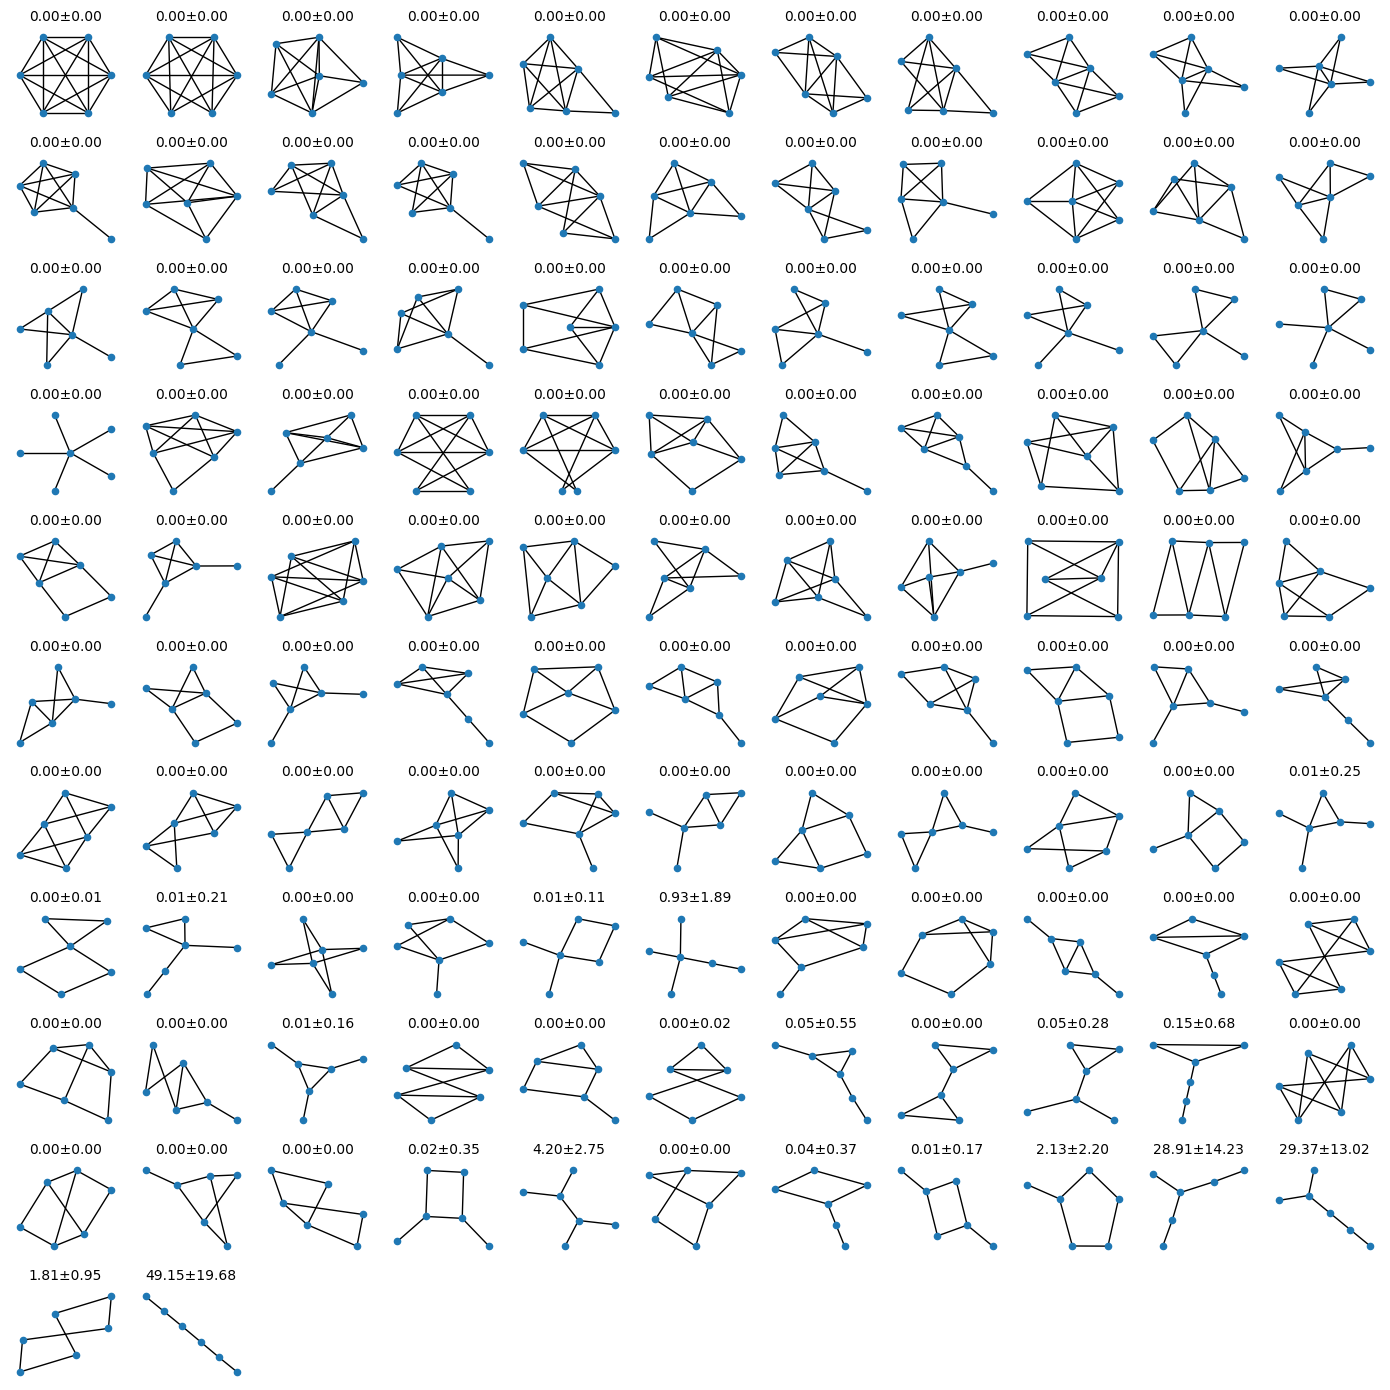

In [30]:
plot_graphs(all_graphs, figsize=14, dotsize=20, avgs=avg_counts, stds=std_counts, title_fontsize=10)

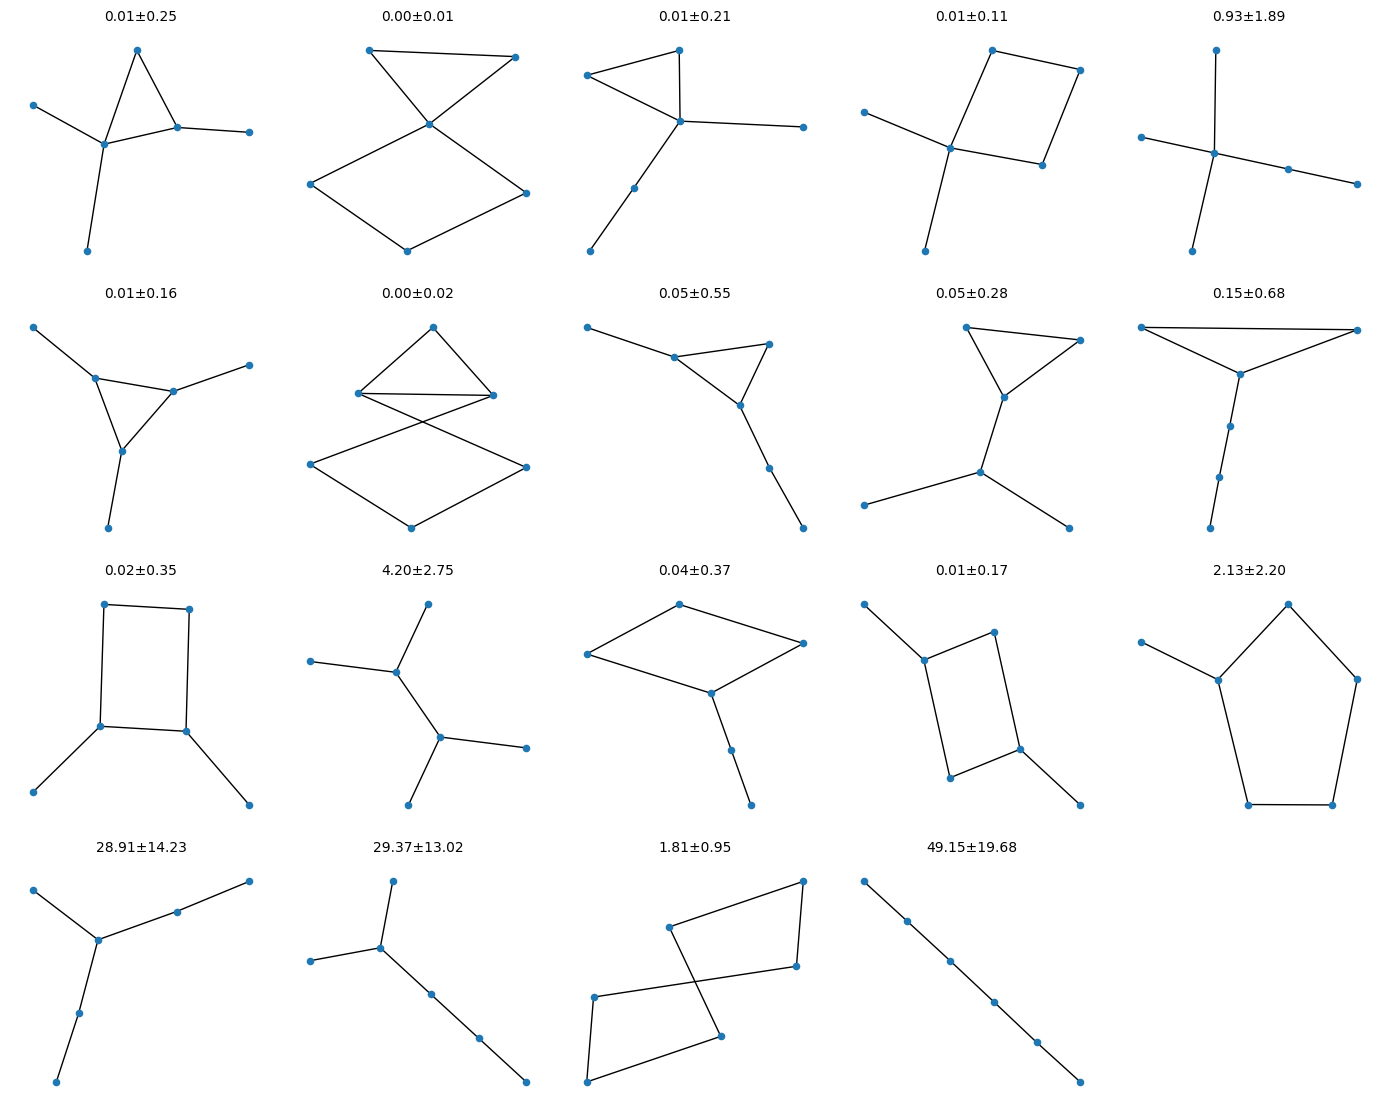

In [32]:
present_patterns = [all_graphs[i] for i in range(len(all_graphs)) if avg_counts[i] != 0]
present_avg_counts = [avg_counts[i] for i in range(len(avg_counts)) if avg_counts[i] != 0]
present_std_counts = [std_counts[i] for i in range(len(avg_counts)) if avg_counts[i] != 0]
plot_graphs(present_patterns, figsize=14, dotsize=20, avgs=present_avg_counts, stds=present_std_counts, title_fontsize=10)

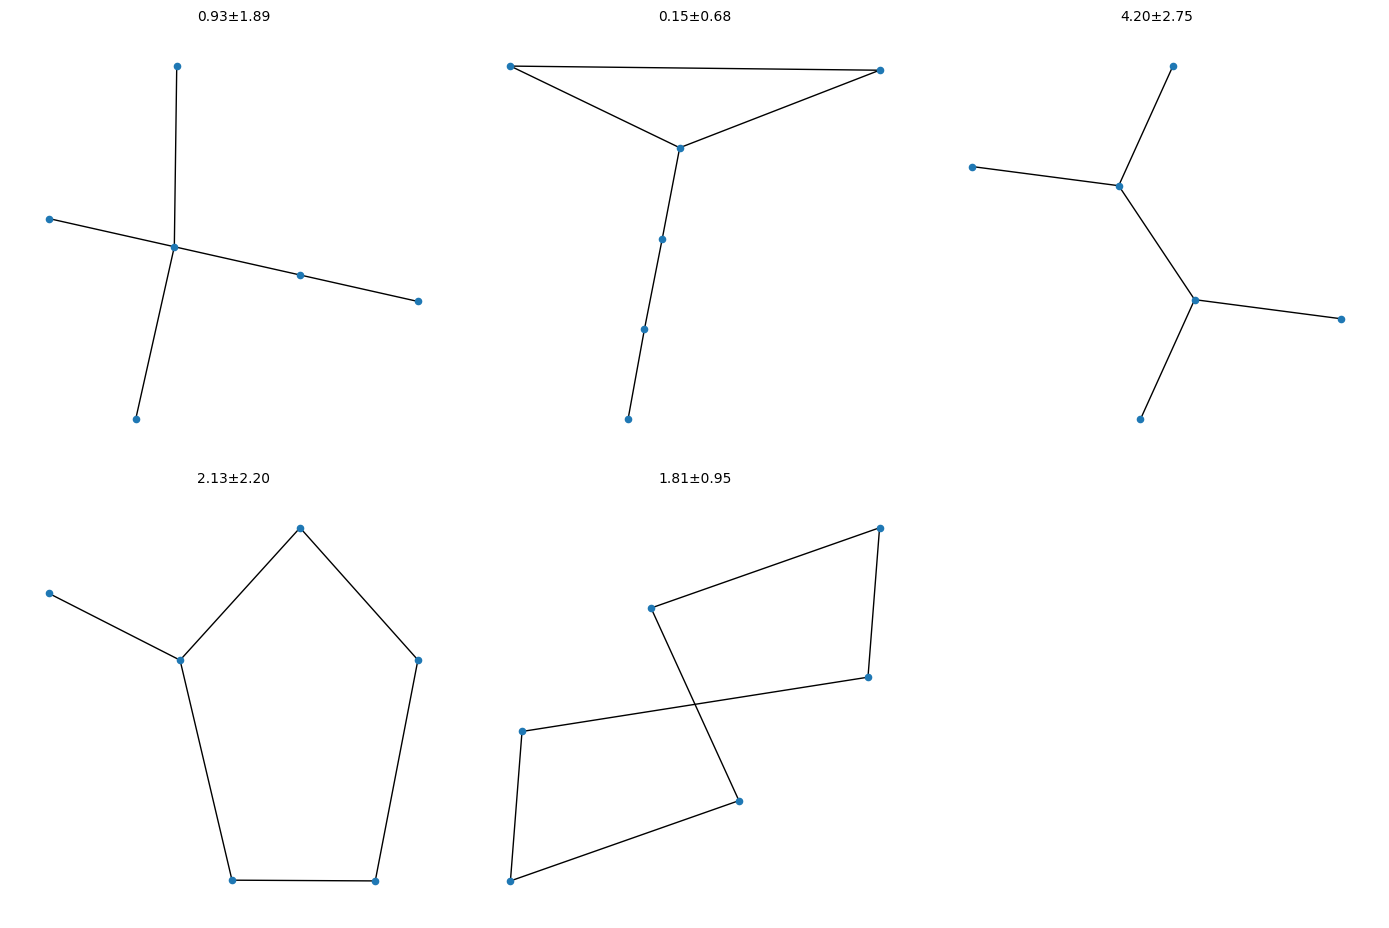

In [35]:
present_patterns = [all_graphs[i] for i in range(len(all_graphs)) if avg_counts[i] > 0.1 and avg_counts[i] < 10]
present_avg_counts = [avg_counts[i] for i in range(len(avg_counts)) if avg_counts[i] > 0.1 and avg_counts[i] < 10]
present_std_counts = [std_counts[i] for i in range(len(avg_counts)) if avg_counts[i] > 0.1 and avg_counts[i] < 10]
plot_graphs(present_patterns, figsize=14, dotsize=20, avgs=present_avg_counts, stds=present_std_counts, title_fontsize=10)

In [1]:
import pickle
with open('substructures.pkl', 'wb') as f:
    pickle.dump(present_patterns, f)
print("Saved the useful graphs.")

NameError: name 'present_patterns' is not defined

In [5]:
with open('substructures.pkl', 'rb') as f:
    loaded_graphs = pickle.load(f)

In [6]:
loaded_graphs

[[(0, 1), (0, 2), (0, 3), (0, 4), (1, 5)],
 [(0, 1), (0, 2), (0, 3), (1, 2), (3, 4), (4, 5)],
 [(0, 1), (0, 2), (0, 3), (1, 4), (1, 5)],
 [(0, 1), (0, 2), (0, 3), (1, 4), (2, 5), (4, 5)],
 [(0, 1), (0, 2), (1, 3), (2, 4), (3, 5), (4, 5)]]

In [4]:
triangle = [[(0,1), (1,2), (2,0)]]

import pickle
with open('triangle.pkl', 'wb') as f:
    pickle.dump(triangle, f)
print("Saved the useful graphs.")

Saved the useful graphs.


In [11]:
cycles_3_8 = [list(nx.cycle_graph(i).edges) for i in range(3,9)]
cycles_3_8
import pickle
with open('cycles_3_8.pkl', 'wb') as f:
    pickle.dump(cycles_3_8, f)

[(0, 1), (0, 4), (1, 2), (2, 3), (3, 4)]